## LSST Solar System Processing

## Linking of Simulated dataset with HelioLinC3D

### Algorithm: 

* Similar to HelioLinC (Holman et al. 2018) we transform topocentric observations to heliocentric states assuming a distance and radial velocity.
* The resulting 3D positions are collected into tracklets. Tracklets contain at least two observations and can, thus, be used to create velocity vectors.
* A tracklet + velocity vector is called an "arrow". 
* Arrows are propagated to a common epoch using spiceypy's 2body propagator, and then clustered using dbscan.
* We calculate a mean state and variance for each cluster (trimmed mean), which is our best guess for the underlying orbit (IOD)
* We can filter all clusters based on their variance

### Implementation:
S. Eggl 20210218
    
### Last modified:
S. Eggl 20220627

In [60]:
# HelioLinC3D Solar System Processing functions for LSST
import heliolinc3d as hl

In [61]:
# Did I Find It Analysis tool (Moeyens et al.)
import difi

In [62]:
from difi import __version__
print("difi version: {}".format(__version__))

difi version: 1.1


In [63]:
# Demo relevant python modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [64]:
# Joblib prallelization
import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [65]:
# Progress bar for joblib processes
import contextlib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback:
        def __init__(self, time, index, parallel):
            self.index = index
            self.parallel = parallel

        def __call__(self, index):
            tqdm_object.update()
            if self.parallel._original_iterator is not None:
                self.parallel.dispatch_next()

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()   

## SIMULATED OBSERVATIONS 


### Select observations from LSST Survey Simulation Dataset

Cornwall et al. 2021, 3deg x 3deg, 16 nights 

In [68]:
dfObs=pd.read_hdf('examples/data/S3M_LSST_test_observations.h5')

In [69]:
dfObs

ObjID  FieldID      FieldMJD  AstRange(km)  AstRangeRate(km/s)  \
0      S1005zBsa      322  59854.134964  3.903528e+08           18.438325   
1      S1000BHqa      323  59854.135412  1.335147e+08            9.922900   
2      S10032DHa      323  59854.135412  3.540569e+08           16.413993   
3      S100KUqra      323  59854.135412  2.009614e+08           17.690016   
4      S1005AL4a      323  59854.135412  3.323034e+08           17.218939   
...          ...      ...           ...           ...                 ...   
14202  S100pEx6a    12164  59869.998580  3.514039e+08           21.531036   
14203  S100MzuSa    12164  59869.998580  2.545696e+08           20.386812   
14204  S100JDrza    12164  59869.998580  3.222315e+08           22.449487   
14205  S1004VwEa    12164  59869.998580  3.672006e+08           23.023468   
14206  S100j6zBa    12164  59869.998580  3.212131e+08           16.304325   

       AstRA(deg)  AstRARate(deg/day)  AstDec(deg)  AstDecRate(deg/day)  \
0      317.007162           -0.012928    -5.883793            -0.034805   
1      317.230318            0.121660    -7.215994            -0.021378   
2      317.621096           -0.046593    -7.659217            -0.074332   
3      317.008627            0.068307    -7.344556            -0.051081   
4      317.067163           -0.008325    -7.480742            -0.087330   
...           ...                 ...          ...                  ...   
14202  317.190970            0.079577    -5.130440            -0.015811   
14203  317.101661            0.166477    -5.140825            -0.050978   
14204  317.083692            0.088453    -5.318370             0.032007   
14205  317.243144            0.070462    -5.068241            -0.000824   
14206  317.032211            0.063046    -5.273178            -0.046266   

       Ast-Sun(J2000x)(km)  ...         SNR  AstrometricSigma(deg)  \
0             4.320857e+08  ...   15.131873               0.000012   
1             2.453059e+08  ...  775.318617               0.000003   
2             4.072802e+08  ...   13.911700               0.000013   
3             2.938590e+08  ...    6.129057               0.000029   
4             3.892966e+08  ...   27.161090               0.000007   
...                    ...  ...         ...                    ...   
14202         3.926581e+08  ...    8.990583               0.000018   
14203         3.216310e+08  ...    5.215250               0.000030   
14204         3.708631e+08  ...    6.651233               0.000024   
14205         4.044528e+08  ...   13.797897               0.000012   
14206         3.699418e+08  ...   19.627342               0.000008   

       MaginFilter  dmagDetect  AstRATrue(deg)  AstDecTrue(deg)  filter  \
0        20.706603    0.000562      317.007156        -5.883805       y   
1        14.952667    0.006333      317.230318        -7.215994       y   
2        20.866671    0.003237      317.621091        -7.659233       y   
3        21.697419    0.003044      317.008629        -7.344537       y   
4        20.070287    0.003253      317.067154        -7.480754       y   
...            ...         ...             ...              ...     ...   
14202    23.400043    0.003453      317.190977        -5.130444       r   
14203    23.813880    0.015719      317.101637        -5.140838       r   
14204    23.744959    0.004636      317.083701        -5.318376       r   
14205    22.917715    0.002606      317.243159        -5.068255       r   
14206    22.376534    0.003215      317.032204        -5.273178       r   

       class  obsName  obsId  
0        MBA   956799      0  
1        MBA   832613      1  
2        MBA   859226      2  
3        MBA  7993708      3  
4        MBA   687450      4  
...      ...      ...    ...  
14202    MBA  6410097  14202  
14203    MBA  8257306  14203  
14204    MBA  8257947  14204  
14205    MBA  1202269  14205  
14206    MBA  5112601  14206  

[14207 rows x 37 columns]

<AxesSubplot:>

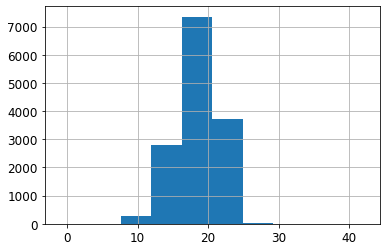

In [126]:
dfObs['AstRangeRate(km/s)'].hist()

In [70]:
dfObs['obsId']

0            0
1            1
2            2
3            3
4            4
         ...  
14202    14202
14203    14203
14204    14204
14205    14205
14206    14206
Name: obsId, Length: 14207, dtype: int64

In [71]:
# convert observations to HelioLinC ingestible format

dfHeliolincInput=hl.obs2heliolinc(dfObs);

dict_values(['obsName', 'FieldMJD', 'AstRA(deg)', 'AstDec(deg)'])


In [72]:
# add observer states for observation epochs
dfHeliolincInput[['x_obs','y_obs','z_obs']], dfHeliolincInput[['vx_obs','vy_obs','vz_obs']] = hl.getObserverStates(dfHeliolincInput['time'],origin='SSB',observer_location='I11',ephemeris_dt='1h',frame='ecliptic')

In [73]:
dfHeliolincInput['night'] = hl.whichNight(dfHeliolincInput['time'])

In [74]:
dfHeliolincInput

obsName          time          RA       DEC  obsId     x_obs     y_obs  \
0       956799  59854.135765  317.007162 -5.883793      0  0.998881  0.148955   
1       832613  59854.136212  317.230318 -7.215994      1  0.998879  0.148963   
2       859226  59854.136212  317.621096 -7.659217      2  0.998879  0.148963   
3      7993708  59854.136212  317.008627 -7.344556      3  0.998879  0.148963   
4       687450  59854.136212  317.067163 -7.480742      4  0.998879  0.148963   
...        ...           ...         ...       ...    ...       ...       ...   
14202  6410097  59869.999381  317.190970 -5.130440  14202  0.917479  0.408951   
14203  8257306  59869.999381  317.101661 -5.140825  14203  0.917479  0.408951   
14204  8257947  59869.999381  317.083692 -5.318370  14204  0.917479  0.408951   
14205  1202269  59869.999381  317.243144 -5.068241  14205  0.917479  0.408951   
14206  5112601  59869.999381  317.032211 -5.273178  14206  0.917479  0.408951   

          z_obs    vx_obs    vy_obs    vz_obs  night  
0     -0.000232 -0.002816  0.017164 -0.000091  59854  
1     -0.000232 -0.002816  0.017164 -0.000091  59854  
2     -0.000232 -0.002816  0.017164 -0.000091  59854  
3     -0.000232 -0.002816  0.017164 -0.000091  59854  
4     -0.000232 -0.002816  0.017164 -0.000091  59854  
...         ...       ...       ...       ...    ...  
14202 -0.000243 -0.007184  0.015780 -0.000067  59870  
14203 -0.000243 -0.007184  0.015780 -0.000067  59870  
14204 -0.000243 -0.007184  0.015780 -0.000067  59870  
14205 -0.000243 -0.007184  0.015780 -0.000067  59870  
14206 -0.000243 -0.007184  0.015780 -0.000067  59870  

[14207 rows x 12 columns]

### Plot LSST Field

In [75]:

fig = px.scatter(dfObs, x="AstRA(deg)", y="AstDec(deg)", color="class",width=700, height=600)
fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
fig.show()

In [76]:

fig = px.scatter(dfObs, x="AstRA(deg)", y="AstDec(deg)", color="class", size='SNR',size_max=30,
                 width=700, height=600)
fig.show()

In [77]:
#hl.plot.plotField(dfin_sel,objName='ObjID',raName='AstRA(deg)',decName='AstDec(deg)')

### Since we are looking at a fraction of the sky, how many nights do we actually observe?

In [78]:
df_grouped_by_night=dfHeliolincInput.groupby('night')

In [79]:
len(df_grouped_by_night.groups)

10

In [80]:
df_grouped_by_night.groups.keys()

dict_keys([59854, 59855, 59860, 59861, 59862, 59863, 59865, 59867, 59869, 59870])

## Run HelioLinC3D

### Choose HelioLinC3D clustering parameters

In [168]:
# Distance limit for tracklet (arrow) generation off of heliocentric positions from neighboring observations [au]
tracklet_construction_dmax = 0.016

# Clustering radius limit for propagated tracklets (arrows) [au]; propagated tracklets beyond this distance do not belong to the same cluster 
propagated_tracklet_dmax = 0.02

# Clusters are filtered by their compactness using the variance of the propagated and clustered tracklets wrt the mean state of clustered tracklets [au^2].
mean_state_variance_limit = 1e-6

# min temporal separation for tracklet generation from observations, e.g. exposure time (days)
t_sep_min=25/86400 

# max temporal separation for tracklet generation (days)
t_sep_max=1.5/24

# Minimum number of arrows to be considered a cluster ('DBSCAN input')
min_samples=3



### Choose heliocentric distance and velocity grid

In [169]:
# define range of heliocentric distances
r_guess=np.arange(2,4,0.2)
#rall=np.arange(6,30,2)
# define range of heliocentric radial velocities
rdot_guess=np.arange(-0.006,0.006,0.001)
np.append(drdtall,0.0)

# Iterator for joblib based paralellization
rrdot_grid=np.array(np.meshgrid(r_guess,rdot_guess)).T.reshape(-1,2)

# How many configuraitons do we have to run?
print(len(rrdot_grid))

120


In [170]:
import importlib
importlib.reload(hl)
import heliolinc2 as hl

In [171]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
%autoreload 2

In [173]:
dftrails = pd.DataFrame([])

In [174]:
dftrails

Empty DataFrame
Columns: []
Index: []

In [175]:
helres = hl.heliolinc2(r_guess[4], rdot_guess[-1], tracklet_construction_dmax, 
                       propagated_tracklet_dmax, t_sep_min, t_sep_max, 
                     dfobs=dfHeliolincInput, dftrails=dftrails,
                     min_samples=min_samples,
                     light_time=True, 
                     verbose=True, mean_state_variance_limit=mean_state_variance_limit) 
                     

obsids [[   16    42]
 [   34    42]
 [   29    42]
 ...
 [12847 13400]
 [12966 13416]
 [13202 13624]]
nobsarrows 10 704787
tarrow [59854.13621249 59854.13621249 59854.13621249 ... 59869.99531274
 59869.99531274 59869.99531274]
xarrow [[ 2.4640086  -1.20779848  0.29132671]
 [ 2.46326557 -1.20902029  0.29256616]
 [ 2.46338732 -1.20863626  0.29313322]
 ...
 [ 2.61627437 -1.04329126  0.35439546]
 [ 2.61386743 -1.04609875  0.36375686]
 [ 2.6147958  -1.04450401  0.36166114]]
varrow [[-1.73383383e-01 -2.09745233e-01  6.53523670e-01]
 [ 5.30279342e-02  1.62832252e-01  2.77188351e-01]
 [ 1.58133982e-02  4.54496758e-02  1.03835448e-01]
 ...
 [ 8.41394945e-03  8.98819411e-03  2.63722435e-03]
 [ 7.28495022e-03  5.89572800e-03  1.91137399e-03]
 [ 6.93816558e-03  4.43429051e-03  1.63411224e-04]]
Number of arrows generated:  704787
Propagating arrows...
Propagated arrows xyz [[ 1.08826183 -2.8709388   5.47426945]
 [ 2.88289375  0.08276977  2.49070363]
 [ 2.58774352 -0.84769392  1.1164512 ]
 ...
 [ 2

In [176]:
helres

clusterId                                        obsId  trailId    r  \
0             0              [27, 42, 704, 1313, 2398, 2558]       -1  2.8   
1             1              [20, 73, 716, 1310, 2380, 2539]       -1  2.8   
2             2                    [34, 49, 710, 1315, 2408]       -1  2.8   
3             3  [19, 50, 686, 1098, 1292, 2174, 2411, 2526]       -1  2.8   
4             5   [9, 71, 687, 1097, 1281, 2176, 2379, 2544]       -1  2.8   
...         ...                                          ...      ...  ...   
1050      44311                 [11873, 11970, 12089, 12457]       -1  2.8   
1051      44313                 [11806, 12018, 12345, 12438]       -1  2.8   
1052      44314                 [11668, 11995, 12094, 12420]       -1  2.8   
1053      44353                 [11805, 12019, 12342, 12423]       -1  2.8   
1054      44365   [10923, 11285, 11919, 12248, 12549, 12677]       -1  2.8   

       drdt  cluster_epoch     x_ecl     y_ecl     z_ecl    vx_ecl    vy_ecl  \
0     0.005   59862.067573  2.524544 -1.170422  0.314330  0.007573  0.004869   
1     0.005   59862.067573  2.532977 -1.161912  0.276950  0.008301  0.005521   
2     0.005   59862.067573  2.530890 -1.169335  0.265582  0.008456  0.005301   
3     0.005   59862.067573  2.536381 -1.150494  0.293500  0.008347  0.006123   
4     0.005   59862.067573  2.537415 -1.148173  0.293845  0.008359  0.006237   
...     ...            ...       ...       ...       ...       ...       ...   
1050  0.005   59862.067573  2.564675 -1.073479  0.335695  0.008540  0.008184   
1051  0.005   59862.067573  2.558918 -1.083590  0.350476  0.010199  0.011515   
1052  0.005   59862.067573  2.563814 -1.067128  0.362421  0.009204  0.008201   
1053  0.005   59862.067573  2.564149 -1.066632  0.361617  0.009267  0.008729   
1054  0.005   59862.067573  2.558404 -1.068781  0.391774  0.007593  0.005076   

        vz_ecl       var_pos       var_vel  
0     0.002613  7.881912e-08  1.185640e-09  
1    -0.001002  1.251133e-07  2.251694e-09  
2    -0.003007  7.061535e-08  1.255404e-09  
3     0.000874  1.932209e-08  3.608115e-10  
4     0.001186  1.611342e-08  2.604529e-10  
...        ...           ...           ...  
1050  0.001292  2.265509e-08  8.994822e-10  
1051 -0.001597  8.725205e-09  3.473236e-10  
1052 -0.003931  2.805775e-09  1.116988e-10  
1053 -0.002885  5.666967e-09  2.255198e-10  
1054 -0.000396  5.635255e-08  1.859860e-09  

[1055 rows x 14 columns]

In [177]:
for index, row in helres.iterrows():
    print(dfObs[dfObs['obsId'].isin(helres["obsId"][index])].ObjID)

27      S1007Z5xa
42      S1007Z5xa
704     S1007Z5xa
1313    S1007Z5xa
2398    S1007Z5xa
2558    S1007Z5xa
Name: ObjID, dtype: object
20      S100aNYna
73      S100aNYna
716     S100aNYna
1310    S100aNYna
2380    S100aNYna
2539    S100aNYna
Name: ObjID, dtype: object
34      S100axhFa
49      S100axhFa
710     S100axhFa
1315    S100axhFa
2408    S100axhFa
Name: ObjID, dtype: object
19      S1002qrHa
50      S1002qrHa
686     S1002qrHa
1098    S1002qrHa
1292    S1002qrHa
2174    S1002qrHa
2411    S1002qrHa
2526    S1002qrHa
Name: ObjID, dtype: object
9       S1002bvta
71      S1002bvta
687     S1002bvta
1097    S1002bvta
1281    S1002bvta
2176    S1002bvta
2379    S1002bvta
2544    S1002bvta
Name: ObjID, dtype: object
36      S10004X0a
47      S10004X0a
1106    S10004X0a
1276    S10004X0a
2384    S10004X0a
2546    S10004X0a
Name: ObjID, dtype: object
24      S1008iFAa
60      S1008iFAa
308     S1008iFAa
701     S1008iFAa
1177    S1008iFAa
2349    S1008iFAa
2368    S1008iFAa
2560    S1

176     S10030FXa
914     S10030FXa
1619    S10030FXa
2340    S10030FXa
2500    S10030FXa
2627    S10030FXa
Name: ObjID, dtype: object
553     S1002ifMa
610     S1002ifMa
1574    S1002ifMa
2184    S1002ifMa
2503    S1002ifMa
2586    S1002ifMa
Name: ObjID, dtype: object
557     S1003XfWa
657     S1003XfWa
957     S1003XfWa
1252    S1003XfWa
1356    S1003XfWa
2181    S1003XfWa
2427    S1003XfWa
2629    S1003XfWa
Name: ObjID, dtype: object
371     S100niova
628     S100niova
786     S100niova
1211    S100niova
2462    S100niova
Name: ObjID, dtype: object
371     S100niova
628     S100niova
3454    S100niova
4149    S100niova
4631    S100niova
5061    S100niova
5346    S100niova
5420    S100niova
Name: ObjID, dtype: object
555     S100076la
641     S100076la
936     S100076la
1360    S100076la
2179    S100076la
2472    S100076la
2630    S100076la
Name: ObjID, dtype: object
428     S100d4K7a
644     S100d4K7a
1045    S100d4K7a
1270    S100d4K7a
1472    S100d4K7a
2308    S100d4K7a
2491    S1

525      S1001nt0a
963      S1001nt0a
1753     S1001nt0a
3188     S1001nt0a
3820     S1001nt0a
4601     S1001nt0a
4987     S1001nt0a
5249     S1001nt0a
6833     S1001nt0a
7140     S1001nt0a
8062     S1001nt0a
8125     S1001nt0a
8597     S1001nt0a
9623     S1001nt0a
11352    S1001nt0a
Name: ObjID, dtype: object
491     S1003aXXa
1739    S1003aXXa
2284    S1003aXXa
Name: ObjID, dtype: object
536     S10066Qpa
960     S10066Qpa
1737    S10066Qpa
2278    S10066Qpa
Name: ObjID, dtype: object
291     S100tjeXa
1151    S100tjeXa
1935    S100tjeXa
Name: ObjID, dtype: object
161     S10017T0a
1090    S10017T0a
2292    S10017T0a
Name: ObjID, dtype: object
457     S1007Ih3a
1049    S1007Ih3a
1463    S1007Ih3a
1967    S1007Ih3a
Name: ObjID, dtype: object
447     S1009jGqa
992     S1009jGqa
1408    S1009jGqa
Name: ObjID, dtype: object
440     S100boIFa
989     S100boIFa
1410    S100boIFa
1924    S100boIFa
Name: ObjID, dtype: object
189     S1010A6Aa
1187    S1010A6Aa
2091    S1010A6Aa
Name: ObjID, 

2686    S100629fa
3329    S100629fa
3565    S100629fa
4196    S100629fa
4744    S100629fa
5473    S100629fa
Name: ObjID, dtype: object
2742    S1004jGEa
3449    S1004jGEa
3534    S1004jGEa
4190    S1004jGEa
4816    S1004jGEa
5436    S1004jGEa
Name: ObjID, dtype: object
2687    S1009fi7a
3322    S1009fi7a
3494    S1009fi7a
4225    S1009fi7a
4876    S1009fi7a
5377    S1009fi7a
Name: ObjID, dtype: object
2732    S1008ay9a
3313    S1008ay9a
3550    S1000qeea
4191    S1000qeea
4223    S1008ay9a
4817    S1000qeea
4868    S1008ay9a
5446    S1000qeea
Name: ObjID, dtype: object
2732    S1008ay9a
3313    S1008ay9a
3526    S1008ay9a
4223    S1008ay9a
4868    S1008ay9a
5411    S1008ay9a
5639    S1008ay9a
6213    S1008ay9a
6561    S1008ay9a
7559    S1008ay9a
Name: ObjID, dtype: object
2689    S100hQria
3333    S100hQria
4137    S100hQria
5051    S100hQria
5753    S100hQria
6413    S100hQria
Name: ObjID, dtype: object
3304    S1009ueLa
5076    S1009ueLa
5445    S1009ueLa
Name: ObjID, dtype: object
3

2845    S100fnKqa
3269    S100fnKqa
3640    S100fnKqa
3948    S1004EIMa
4183    S1004EIMa
4655    S1004EIMa
Name: ObjID, dtype: object
2824    S1001DfMa
3291    S1001DfMa
3625    S1001DfMa
4247    S1001DfMa
4508    S1001DfMa
5700    S1001DfMa
6482    S1001DfMa
6790    S1001DfMa
7884    S1001DfMa
Name: ObjID, dtype: object
2809    S100Ag6fa
3276    S100Ag6fa
3700    S100Ag6fa
4271    S100Ag6fa
4305    S100Ag6fa
4947    S100Ag6fa
Name: ObjID, dtype: object
2811    S100y33Ya
3129    S100y33Ya
3823    S100y33Ya
4277    S100y33Ya
4302    S100y33Ya
5086    S100y33Ya
5185    S100y33Ya
5542    S100y33Ya
Name: ObjID, dtype: object
2941    S100uhDQa
3546    S100uhDQa
3925    S100uhDQa
4255    S100uhDQa
4533    S100uhDQa
4777    S100uhDQa
5102    S100uhDQa
Name: ObjID, dtype: object
3253    S1002Qq5a
3525    S1002Qq5a
4254    S1002Qq5a
4625    S1002Qq5a
4751    S1002Qq5a
5879    S1002Qq5a
6417    S1002Qq5a
Name: ObjID, dtype: object
2820    S1000Ea1a
3260    S1000Ea1a
3876    S1000Ea1a
4249    S1

2983    S1004FIxa
3944    S1004FIxa
5273    S1004FIxa
Name: ObjID, dtype: object
3250    S100M9dya
3970    S100M9dya
4604    S100M9dya
Name: ObjID, dtype: object
3008    S1002nJoa
3949    S1002nJoa
4368    S1002nJoa
5218    S1002nJoa
Name: ObjID, dtype: object
4526    S1003xGJa
4593    S1008Uafa
4676    S1003xGJa
5188    S100cIx3a
5344    S100cIx3a
5351    S100hjdOa
Name: ObjID, dtype: object
3290    S1002DCma
3660    S1002DCma
3792    S1002DCma
3842    S100cwfHa
4603    S100cwfHa
4708    S100cwfHa
Name: ObjID, dtype: object
3241    S1010A6Aa
4076    S1010A6Aa
4394    S1010A6Aa
4689    S1010A6Aa
5176    S1010A6Aa
5361    S1010A6Aa
Name: ObjID, dtype: object
2836    S1002NuCa
3345    S1002NuCa
3649    S1002NuCa
3889    S1002NuCa
4166    S1002NuCa
4633    S1002NuCa
5331    S1002NuCa
Name: ObjID, dtype: object
3206    S100pCtUa
3651    S100pCtUa
3957    S100pCtUa
4741    S100pCtUa
5327    S100pCtUa
Name: ObjID, dtype: object
3000    S1000yQRa
3972    S1000yQRa
4730    S1000yQRa
Name: ObjI

7106     S1004EPsa
8165     S1004EPsa
8684     S1004EPsa
9646     S1004EPsa
10348    S1004EPsa
Name: ObjID, dtype: object
6829    S100NP3ua
7203    S100NP3ua
7812    S100kfsMa
8082    S100kfsMa
Name: ObjID, dtype: object
6854    S100NsIza
7071    S100NsIza
7969    S1009cJja
8472    S1009cJja
Name: ObjID, dtype: object
6854    S100NsIza
7071    S100NsIza
7941    S100NsIza
8092    S100NsIza
Name: ObjID, dtype: object
6857    S1002qwga
7093    S1002qwga
7946    S1002qwga
8251    S1002qwga
Name: ObjID, dtype: object
7941     S100NsIza
8092     S100NsIza
11674    S100NsIza
11994    S100NsIza
12080    S100NsIza
Name: ObjID, dtype: object
6866    S1001sana
7101    S1001sana
7969    S1009cJja
8472    S1009cJja
Name: ObjID, dtype: object
6867    S1005bdha
7103    S1005bdha
7922    S1005bdha
8079    S1005bdha
Name: ObjID, dtype: object
6692    S100uo63a
7258    S100uo63a
7922    S1005bdha
8079    S1005bdha
Name: ObjID, dtype: object
7246    S100uNK9a
8052    S100uNK9a
8119    S100uNK9a
9022    S

8629     S1003ZDNa
9724     S1003ZDNa
10374    S1003ZDNa
11128    S1003ZDNa
Name: ObjID, dtype: object
8662     S1001OuHa
9713     S1001OuHa
11117    S1001OuHa
Name: ObjID, dtype: object
8692     S100QkxHa
9704     S100QkxHa
10323    S100QkxHa
10951    S100QkxHa
Name: ObjID, dtype: object
8828     S100rvjUa
9523     S100rvjUa
10428    S100rvjUa
Name: ObjID, dtype: object
8813     S100RqIwa
9503     S100RqIwa
10434    S100RqIwa
11561    S100RqIwa
Name: ObjID, dtype: object
8708     S100Gdvya
9702     S100Gdvya
10454    S100Gdvya
Name: ObjID, dtype: object
9347     S101H9vpa
9951     S101H9vpa
10811    S101H9vpa
10997    S101H9vpa
11188    S101H9vpa
Name: ObjID, dtype: object
8724     S100Ge77a
9754     S100Ge77a
10961    S100Ge77a
11450    S100Ge77a
Name: ObjID, dtype: object
8712     S100LNzga
9731     S100LNzga
10352    S100LNzga
10616    S100LNzga
10957    S100LNzga
11466    S100LNzga
Name: ObjID, dtype: object
9946     S101uDH4a
10785    S101uDH4a
11089    S101uDH4a
11542    S101uDH

9281     S100w6FXa
9392     S100w6FXa
11002    S100x50ua
11529    S100x50ua
Name: ObjID, dtype: object
9281     S100w6FXa
9392     S100w6FXa
9764     S100w6FXa
10245    S100w6FXa
10593    S100w6FXa
11003    S100w6FXa
Name: ObjID, dtype: object
9168     S1002NuCa
9514     S1002NuCa
10464    S1002NuCa
10716    S1002NuCa
11198    S1002NuCa
Name: ObjID, dtype: object
9319     S100Gw0Ca
9719     S100Gw0Ca
10336    S100Gw0Ca
10876    S100Gw0Ca
11598    S100Gw0Ca
Name: ObjID, dtype: object
8761     S100nZ0Da
9368     S100nZ0Da
9995     S100nZ0Da
10842    S100nZ0Da
11544    S100nZ0Da
Name: ObjID, dtype: object
9286     S100D1GTa
9371     S100D1GTa
9766     S100D1GTa
10539    S100D1GTa
11382    S100D1GTa
Name: ObjID, dtype: object
9183     S100435Ta
9365     S100435Ta
9516     S100435Ta
10679    S100435Ta
11197    S100435Ta
Name: ObjID, dtype: object
8895     S100c43Ja
9391     S100c43Ja
11082    S100VumVa
11230    S100VumVa
Name: ObjID, dtype: object
8895     S100c43Ja
9391     S100c43Ja
10972

In [178]:
# Parallelize over a grid of initial conditions

n_cores=10

with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot_grid))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          (r, rdot, 
                                           tracklet_construction_dmax, 
                                           propagated_tracklet_dmax, 
                                           t_sep_min, t_sep_max, 
                                           dfobs=dfHeliolincInput,
                                           dftrails=dftrails,
                                           min_samples=min_samples,
                                           light_time=False, 
                                           verbose=False, 
                                           mean_state_variance_limit=mean_state_variance_limit) 
                                           for r, rdot in rrdot_grid ) 



HelioLinC2: 100%|██████████| 120/120 [13:51<00:00,  6.93s/it] 
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is

## Resulting Linkages

In [149]:
# each set of initial conditions produces a data frame with linkages; we merge all of them and give them a unique index
clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
clustered_observations['clusterId']=clustered_observations.index

In [150]:
# Number of clusters respresenting potential objects 
len(clustered_observations)

91109

In [151]:
# deduplicate clusters with the same observations
dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
dedupe['cluster_Id']=dedupe.index

In [152]:
dedupe.head()

clusterId                                              obsId  trailId    r  \
0      71043            [0, 39, 122, 406, 782, 984, 1712, 2014]       -1  3.6   
1      13309                      [1, 55, 351, 792, 1547, 1848]       -1  2.6   
2      15629  [12, 51, 426, 684, 825, 1303, 1535, 2115, 2370...       -1  2.6   
3      11197  [12, 51, 426, 684, 825, 1303, 1535, 2115, 2370...       -1  2.4   
4       7216                     [2, 58, 683, 2110, 2414, 2529]       -1  2.2   

    drdt  cluster_epoch     x_ecl     y_ecl     z_ecl    vx_ecl    vy_ecl  \
0  0.002   59862.067573  3.135354 -1.694481  0.510152  0.006237  0.007365   
1 -0.006   59862.067573  2.394140 -0.975815  0.277217  0.001209  0.018336   
2 -0.002   59862.067573  2.384282 -0.998461  0.278949  0.002812  0.012177   
3  0.003   59862.067573  2.228459 -0.856970  0.248127  0.006527  0.008664   
4  0.005   59862.067573  2.067014 -0.725704  0.203527  0.007232  0.005519   

     vz_ecl       var_pos       var_vel  cluster_Id  
0  0.000792  1.513554e-07  2.514347e-09           0  
1 -0.001629  8.643655e-08  8.372375e-10           1  
2  0.000695  6.717189e-07  3.109286e-08           2  
3  0.001501  5.656435e-07  4.027570e-09           3  
4  0.000738  8.598930e-08  1.183473e-09           4

In [153]:
# Number of clusters respresenting potential objects after deduplication
len(dedupe)

4418

## Run DIFI

In [154]:
# DIFI compares clusters and objects that were linked through HelioLinC3D to the best case scenario.
dfdifi=hl.linkages2difi(dedupe,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

classes_dict = {}
for c in dfin_sel["class"].unique():
    classes_dict[c] = dfin_sel[dfin_sel["class"].isin([c])]["ObjID"].unique()

(all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, dedupe, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages",
                                                          classes=classes_dict)



In [155]:
summary_heliolinc

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All         1875    14207     88.330871       677    742             598   
1   MBA         1866    14180     88.461538       676    742             598   
2   NEO            9       27      0.000000         1      0               0   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0               79                 144                 1054  ...   
1               78                 144                 1046  ...   
2                1                   0                    8  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                                0                                   54   
1                                0                                   54   
2                                0                                    0   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                          54                                      58   
1                          54                                      58   
2                           0                                       0   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                       507                 25876   
1                       507                 25858   
2                         0                    18   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           1903                      833   
1                           1896                      833   
2                              7                        0   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                  146                   3623  
1                                  146                   3623  
2                                    0                      0  

[3 rows x 31 columns]

In [156]:
# purity of the found linkages [%]
summary_heliolinc.pure_linkages/summary_heliolinc.linkages*100

0     85.196922
1     85.180150
2    100.000000
dtype: float64

In [157]:
# The number of clusters containing potential objects is still high wrt to the number of actual objects in the data. 
len(dedupe)

4418

## Mean State Filtering

In [163]:
# Filtering clusters with respect to their internal dispersion will select the best candidates for objects
variance_limit=1e-7
msf=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
msf['cluster_Id']=msf.index

In [164]:
# number of resulting clusters
len(msf)

3414

In [165]:
dfdifi=hl.linkages2difi(msf,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

(all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, msf, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")

In [166]:
# Now we have roughly as many clusters as there are objects to be discovered. However, the completenss took a hit.
summary_heliolinc

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All         1875    14207      84.78582       677    707             574   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0              103                 133                 1065  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                                0                                    3   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                           3                                       3   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                        50                 22349   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           1432                       28   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                    6                    202  

[1 rows x 31 columns]

In [167]:
# purity
summary_heliolinc.pure_linkages/summary_heliolinc.linkages*100

0    98.828354
dtype: float64

/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  n[i] = dot(v[i, :], v[i, :])
/data/projects/lsst/heliolinc2/heliolinc2/vector.py:72: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (array(float64, 1d, A),

In [96]:
# Now we have roughly as many clusters as there are objects to be discovered. However, the completenss took a hit.
summary_heliolinc

class  num_members  num_obs  completeness  findable  found  findable_found  \
0   All         2765    26655     88.505747      1305   1494            1155   

   findable_missed  not_findable_found  not_findable_missed  ...  \
0              150                 339                 1121  ...   

   unique_in_partial_linkages_only  unique_in_pure_and_partial_linkages  \
0                                0                                    6   

   unique_in_partial_linkages  unique_in_partial_contaminant_linkages  \
0                           6                                       6   

   unique_in_mixed_linkages  obs_in_pure_linkages  \
0                        96                 48744   

   obs_in_pure_complete_linkages  obs_in_partial_linkages  \
0                           3830                      118   

   obs_in_partial_contaminant_linkages  obs_in_mixed_linkages  
0                                   20                    551  

[1 rows x 31 columns]

In [97]:
# purity
summary_heliolinc.pure_linkages/summary_heliolinc.linkages*100

0    98.680814
dtype: float64

### Run HelioLinC3D for different clustering parameters


In [149]:
# How do completeness and purity change with varying clustering parameters?
cr_arrow_range=np.arange(0.006,0.016,0.001)

In [150]:
cr_arrow_range

array([0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013, 0.014,
       0.015])

In [151]:
cr_arrow_range=np.arange(0.006,0.016,0.001)

results=[]

for cr_arrows in cr_arrow_range:
    # Clustering radius for heliocentric positions projected from observations [au]
    cr_obs=0.06
    # Clustering radius for propagated arrows [au]
    #cr_arrows=0.012
    # max temporal separation for tracklet observations (days)
    ct_max=1.5/24
    # min temporal separation for tracklet observations, e.g. exposure time (days)
    ct_min=25/86400 
    # Minimum number of arrows to be clustered ('DBSCAN only')
    min_samples=3


    # define range of heliocentric distances
    rall=np.arange(1.8,3.3,0.1)

    # define range of heliocentric radial velocities
    drdtall=np.arange(-0.01,0.0151,0.001)
    np.append(drdtall,0.0)

    # Iterator for joblib based paralellization
    rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

    # How many configuraitons do we have to run?
    print(len(rrdot))


    n_cores=10

    with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                           clustering_algorithm='dbscan', light_time=False, 
                                           verbose=False, n_jobs=1) 
                                           for r, drdt in rrdot ) 

    clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
    clustered_observations['clusterId']=clustered_observations.index

    dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
    dedupe['cluster_Id']=dedupe.index

    dfdifi=hl.linkages2difi(dedupe,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
    dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
    dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

    (all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, dedupe, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")

    results.append([cr_arrows,all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects])

HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   5%|▌         | 20/390 [00:01<00:32, 11.46it/s]


KeyboardInterrupt: 

## Study ROC curve before filtering

In [42]:
# monitor completeness numbers as function of clustering parameter
for r in results:
    print(r[0],r[6].completeness[0])

0.006 88.37209302325581
0.007 89.30232558139535
0.008 92.55813953488372
0.009000000000000001 94.4186046511628
0.01 94.88372093023256
0.011 95.81395348837209
0.012 97.20930232558139
0.013000000000000001 97.20930232558139
0.014 97.20930232558139
0.015000000000000001 97.67441860465117


In [43]:
# generate ROC data 
roc=[]
for r in results:
    roc.append([r[0],r[6].completeness[0],r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id)])
roc=np.array(roc)    

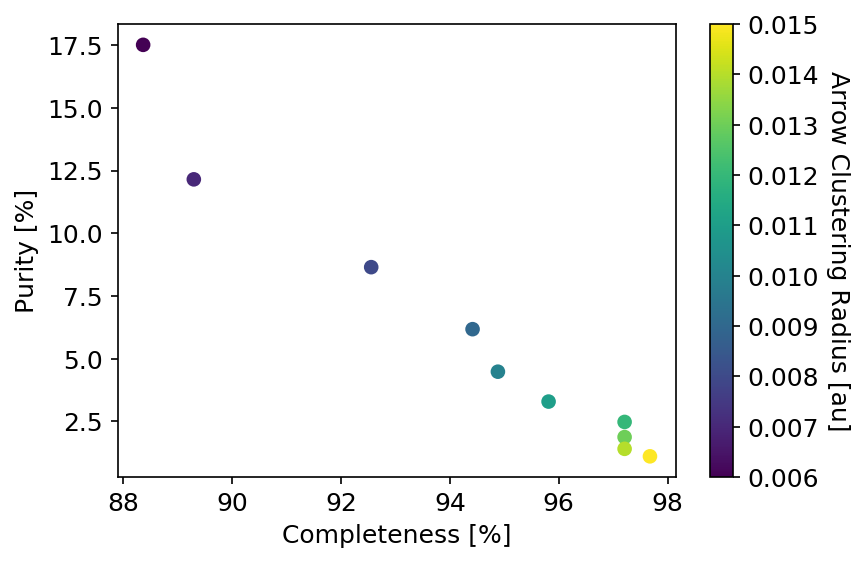

In [44]:
# plot ROC curve
plt.figure(dpi=150)
plt.scatter(roc[:,1],roc[:,2],c=roc[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Purity [%]')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

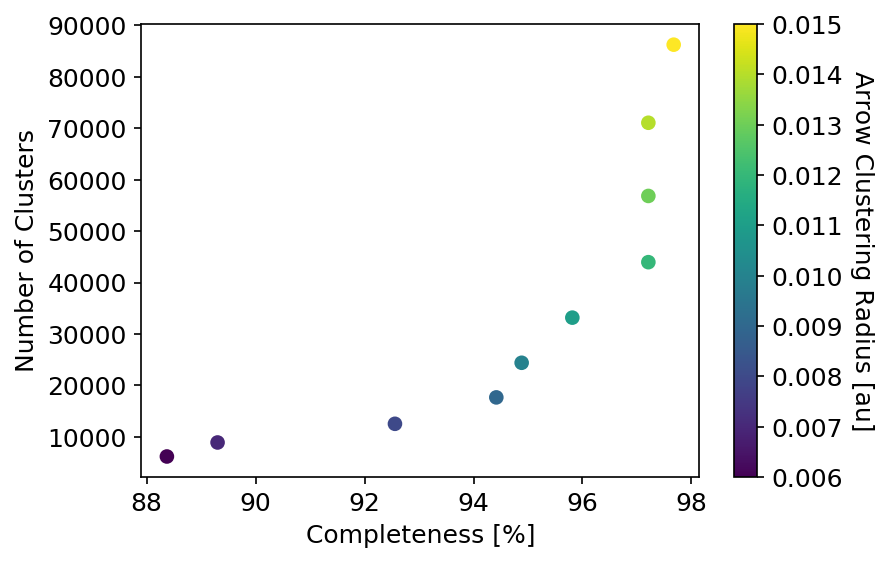

In [45]:
# Number of clusters vs completeness
plt.figure(dpi=150)
plt.scatter(roc[:,1],roc[:,3],c=roc[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Number of Clusters')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

## Rerun HelioLinC3D for different clustering parameters with mean state filtering

In [121]:

def heliolinc_roc(cr_arrow_range=np.arange(0.006,0.016,0.001),cr_obs=0.06,
                  ct_max=1.5/24, ct_min=25/86400, min_samples=3,
                  rall=np.arange(1.8,3.3,0.1),drdtall=np.append(np.arange(-0.01,0.0151,0.002),0),
                  n_cores=10, mean_state_filter_variance_limit=5e-8):
    """ Generate ROC data for HelioLinC3D. 
    
    Parameters:
    -----------
    cr_arrow_range    ... numpy array, Clustering radii for propagated arrows [au]
    cr_obs            ... float, Clustering radius for heliocentric positions projected from observations [au]
    ct_max            ... float, Maximum temporal separation for tracklet observations (days)
    min_samples       ... integer, Minimum number of arrows to be clustered ('DBSCAN only')
    rall              ... numpy array, Range of heliocentric distances searched by HelioLinC [au]
    rrdot             ... numpy array, Range of heliocentric radial velocities searched by HelioLinC [au/day]
    n_cores           ... integer, Number of cores available
    mean_state_filter_variance_limit ... float, Variance limit for mean state filtering 
                          of clusters (positions) [au^2]
                          
    Returns:
    --------
    
    """
    
    results=[]
    
    for cr_arrows in cr_arrow_range:


        # Iterator for joblib based paralellization
        rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

        # How many configuraitons do we have to run in total?
        print("Configurations to run:" len(rrdot)*len(cr_arrow_range))


        n_cores=10

        with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
            clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                              (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                               clustering_algorithm='dbscan', light_time=False, 
                                               verbose=False, n_jobs=1) 
                                               for r, drdt in rrdot ) 

        clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
        clustered_observations['clusterId']=clustered_observations.index

        dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
        #filtering
        cog2=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
        cog2['cluster_Id']=cog2.index

        dfdifi=hl.linkages2difi(cog2,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
        dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
        dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

        (all_truths, findable_observations, summary, 
               all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
               findable_objects, missed_objects) = hl.runDifi(dfobs_difi, cog2, 
                                                              obsIdName='obsId', linkageIdName='cluster_Id',
                                                              objIdName='ObjID', nightName='night', timeName='time',
                                                              findability='tracklet', linkage_min_obs=2, 
                                                              max_obs_separation=1.5/24, 
                                                              min_linkage_nights=3, 
                                                              metric="nightly_linkages")

        results.append([cr_arrows,all_truths, findable_observations, summary, 
               all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
               findable_objects, missed_objects])

HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2:   0%|          | 0/390 [00:00<?, ?it/s]

390


HelioLinC2: 100%|██████████| 390/390 [03:26<00:00,  1.88it/s]


## Plot the ROC curve after mean state filtering 

In [126]:
roc_f=[]

for r in results_filtered:
    roc_f.append([r[0],r[6].completeness[0],r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id)])

roc_f=np.array(roc_f)

/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


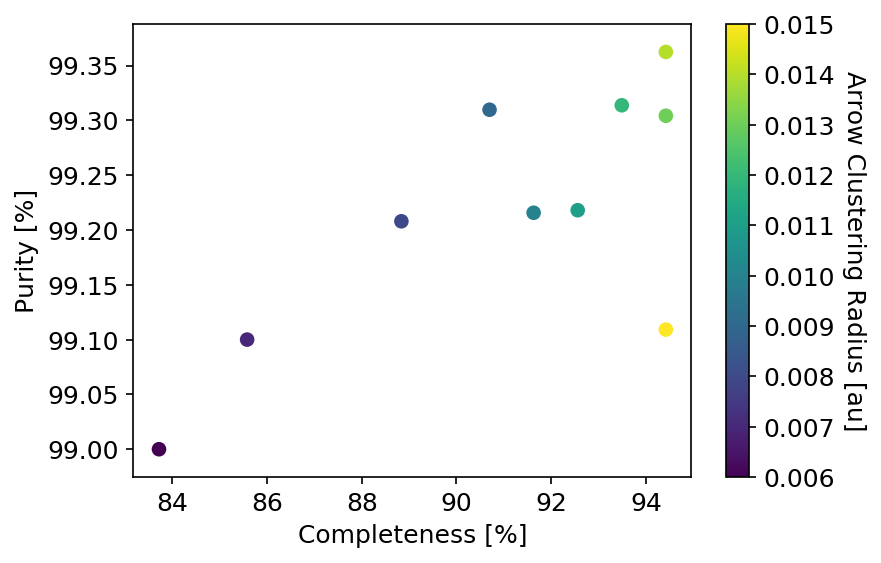

In [127]:
plt.figure(dpi=150)
plt.scatter(roc_f[:,1],roc_f[:,2],c=roc_f[:,0])
plt.xlabel('Completeness [%]')
plt.ylabel('Purity [%]')
cbar = plt.colorbar()
cbar.set_label('Arrow Clustering Radius [au]', rotation=270, labelpad=15)
plt.show()

## The above results are most promising as they show that HelioLinC3D achieves LSST requirements for completeness at a very high purity.

## Create a summary plot.

In [141]:
cr_arrow_range=np.arange(0.002,0.03,0.002)

results_filtered2=[]
variance_limit=5e-8

for cr_arrows in cr_arrow_range:
    # Clustering radius for heliocentric positions projected from observations [au]
    cr_obs=0.06
    # Clustering radius for propagated arrows [au]
    #cr_arrows=0.012
    # max temporal separation for tracklet observations (days)
    ct_max=1.5/24
    # min temporal separation for tracklet observations, e.g. exposure time (days)
    ct_min=25/86400 
    # Minimum number of arrows to be clustered ('DBSCAN only')
    min_samples=3


    # define range of heliocentric distances
    rall=np.arange(1.8,3.3,0.1)

    # define range of heliocentric radial velocities
    drdtall=np.arange(-0.01,0.0152,0.002)
    np.append(drdtall,0.0)

    # Iterator for joblib based paralellization
    rrdot=np.array(np.meshgrid(rall,drdtall)).T.reshape(-1,2)

    # How many configuraitons do we have to run?
    print(len(rrdot))


    n_cores=10

    with tqdm_joblib(tqdm(desc="HelioLinC2", total=len(rrdot))) as progress_bar:
        clusters_df=Parallel(n_jobs=n_cores)(delayed(hl.heliolinc2)
                                          (dfobs, r, drdt, cr_obs, cr_arrows, ct_min, ct_max, min_samples=min_samples,
                                           clustering_algorithm='dbscan', light_time=False, 
                                           verbose=False, n_jobs=1) 
                                           for r, drdt in rrdot ) 

    clustered_observations = (pd.concat(clusters_df)).reset_index(drop=True)  
    clustered_observations['clusterId']=clustered_observations.index

    number_of_clusters=len(clustered_observations.index)
    
    dedupe=hl.deduplicateClusters(clustered_observations.sort_values(by=['var_pos','var_vel']) ).reset_index(drop=True)
    #filtering
    number_of_deduplicated_clusters=len(dedupe.index)
        
    cog2=dedupe[dedupe['var_pos']<variance_limit].reset_index(drop=True)  
    cog2['cluster_Id']=cog2.index

    number_of_filtered_clusters=len(cog2.index)
    
    dfdifi=hl.linkages2difi(cog2,clusterId_name='cluster_Id',observationId_name='obsId',output='pandas')
    dfobs_difi=dfobs.merge(dfin_sel,left_on='obsName',right_on='obsName')
    dfobs_difi['obsId']=dfobs_difi['obsId'].astype(str)

    (all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects) = hl.runDifi(dfobs_difi, cog2, 
                                                          obsIdName='obsId', linkageIdName='cluster_Id',
                                                          objIdName='ObjID', nightName='night', timeName='time',
                                                          findability='tracklet', linkage_min_obs=2, 
                                                          max_obs_separation=1.5/24, 
                                                          min_linkage_nights=3, 
                                                          metric="nightly_linkages")
    print(cr_arrows,summary_heliolinc.completeness)
    results_filtered2.append([cr_arrows,all_truths, findable_observations, summary, 
           all_linkages_heliolinc, all_truths_heliolinc, summary_heliolinc,
           findable_objects, missed_objects,number_of_clusters,number_of_deduplicated_clusters,
                             number_of_filtered_clusters])

HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.002 0    61.395349
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.004 0    77.209302
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.006 0    83.72093
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.008 0    88.837209
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.01 0    91.627907
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.012 0    93.488372
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.014 0    94.418605
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.016 0    94.883721
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.018000000000000002 0    95.348837
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.020000000000000004 0    95.348837
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.022 0    96.744186
Name: completeness, dtype: float64
195


HelioLinC2:   5%|▍         | 9/195 [00:12<06:20,  2.05s/it]/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.024 0    96.744186
Name: completeness, dtype: float64
195


HelioLinC2:   0%|          | 0/195 [00:00<?, ?it/s]

0.026000000000000002 0    96.27907
Name: completeness, dtype: float64
195


HelioLinC2:   4%|▎         | 7/195 [00:11<25:40,  8.19s/it]/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
HelioLinC2: 100%|██████████| 195/195 [01:52<00:00,  1.74it/s]


0.028000000000000004 0    96.27907
Name: completeness, dtype: float64


In [203]:
roc_f2=[]

for r in results_filtered2:
    roc_f2.append([r[0],r[6].completeness[0],
                   r[6].pure_linkages/r[6].linkages*100,len(r[4].cluster_Id),
                   r[9],r[10],r[11],r[6].findable_found+r[6].findable_found ])

roc_f2=np.array(roc_f2)

/epyc/projects/pytrax_play/envs/pytrax_s/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


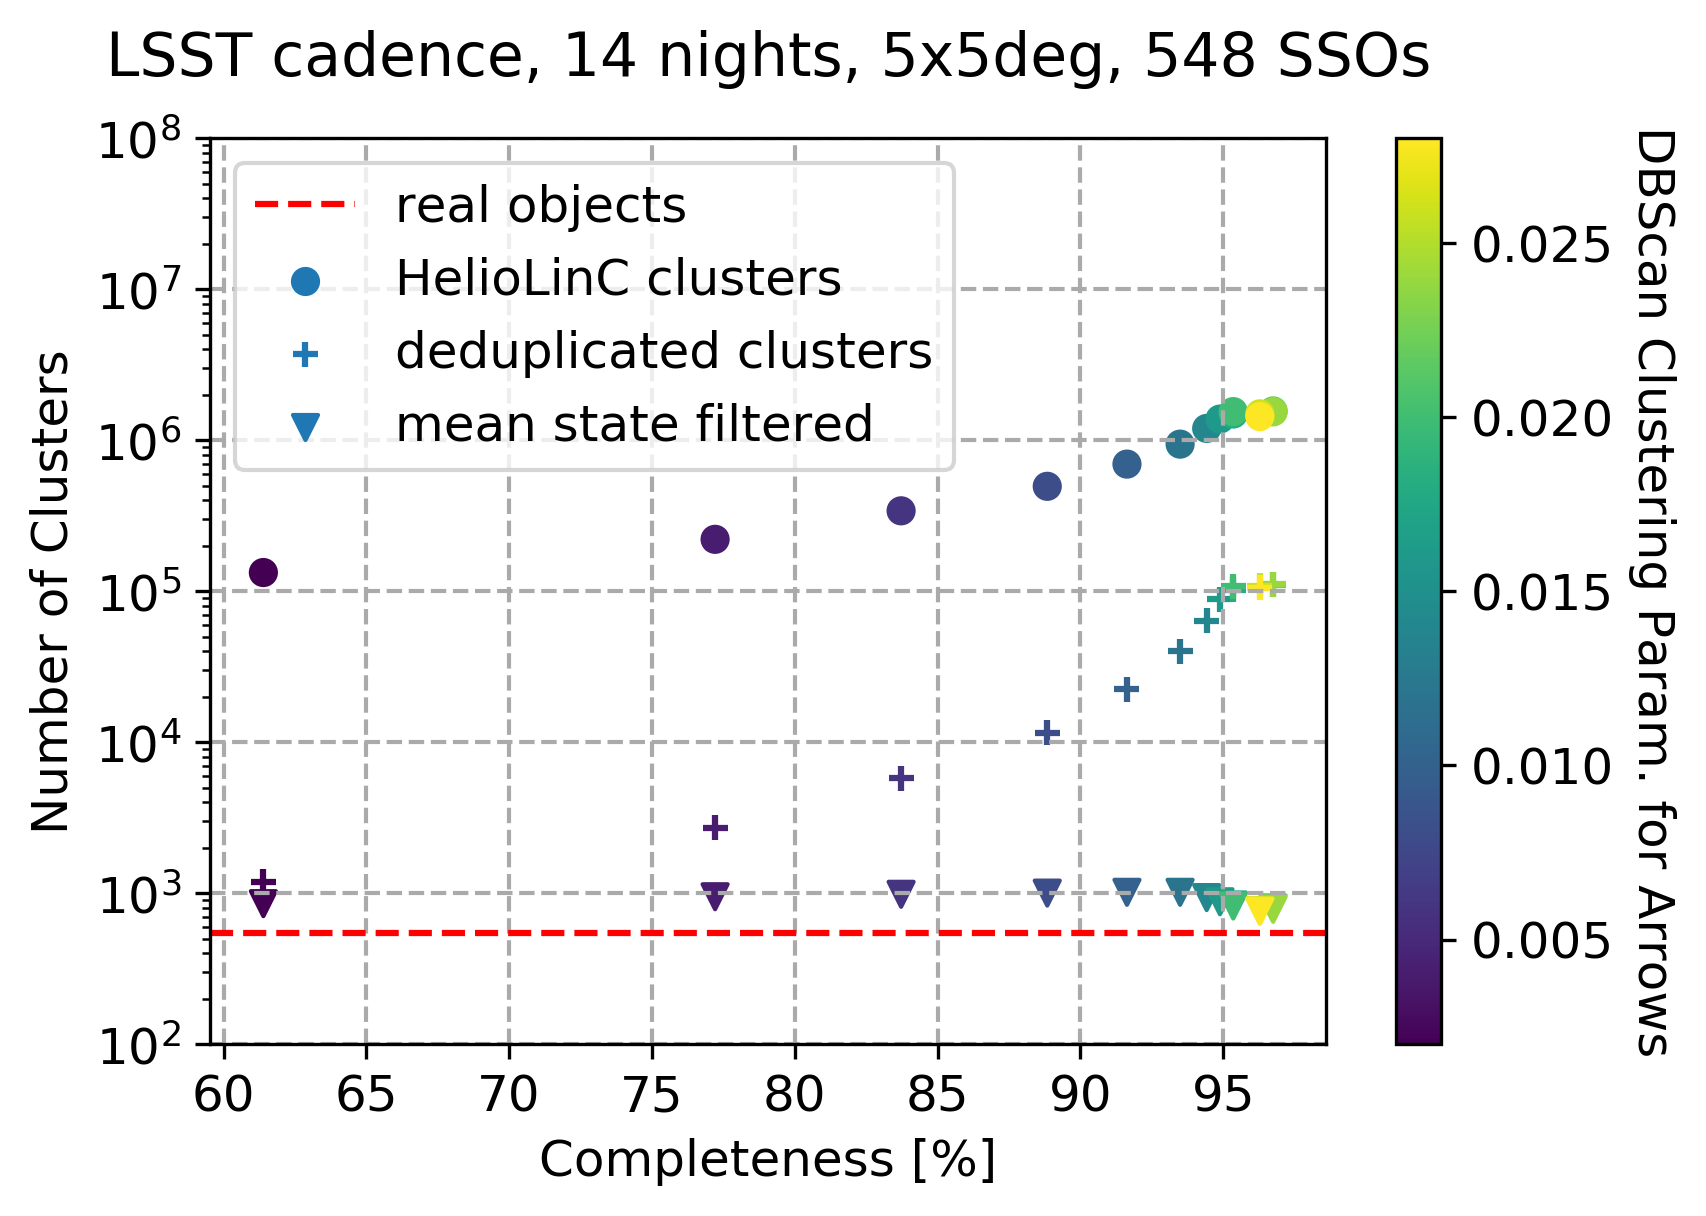

In [227]:
plt.figure(dpi=300)
plt.scatter(roc_f2[:,1],roc_f2[:,4],c=roc_f2[:,0],label='HelioLinC clusters')
plt.scatter(roc_f2[:,1],roc_f2[:,5],c=roc_f2[:,0],label='deduplicated clusters',marker='+')
plt.scatter(roc_f2[:,1],roc_f2[:,3],c=roc_f2[:,0],label='mean state filtered',marker='v')
plt.axhline(y=results_filtered2[0][6].num_members.values, color='r', linestyle='--',label='real objects')
plt.ylim(100,1e8)
plt.xlabel('Completeness [%]')
plt.ylabel('Number of Clusters')
plt.yscale('log')
cbar = plt.colorbar()
cbar.set_label('DBScan Clustering Param. for Arrows', rotation=270, labelpad=15)
plt.xticks(np.arange(60,100,5)) 
plt.grid(color='#AAAAAA', linestyle='--', linewidth=1)
plt.legend(loc='upper left')
plt.title("LSST cadence, 14 nights, 5x5deg, 548 SSOs",pad=15)
plt.show()

# Conclusions

* HelioLinC3D performs at least as good as classical MOPS in terms of finding objects. Currently, it performs best for objects with fewer (~4) observations. 
* Mean state filtering with conservative on sky O-C RMS values allows us to select clusters that are essentially completely free from noise.

